# Logistic Regression from Scratch – Cats vs Dogs Classifier

This notebook implements a logistic regression binary classifier **from scratch** using only `numpy`, without relying on machine learning libraries like `scikit-learn`. 

The goal is to classify images of cats and dogs based on extracted features (e.g., pixel intensities).

---


In [ ]:
# Downloading all necessary libraries.. uncomment if you don't have them installed 
# !pip install numpy matplotlib PiL

In [124]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

%matplotlib inline

## 1. Data Loading & Preprocessing

We load a simplified version of the Cats vs Dogs dataset (500 images per class). Each image is resized to a fixed size and flattened into a feature vector.

*Note:* All preprocessing steps (resize, grayscale, flattening, normalization) are custom-implemented.


In [125]:
def preprocess_image(image_path, img_size=(64,64)): #Grayscaling, resizing, normalizing & flatting the images.
    img = Image.open(image_path).convert("L") # Grayscale
    img = img.resize(img_size) # Resizing
    img_array = np.array(img).flatten().astype(np.float32) / 255.0 # Flatting and  Normalizing
    
    return img_array

> ⚠️ **Note on Data Representation**

In most libraries and academic resources, image data is represented in a **column-wise format**, where each image is reshaped into a column vector (i.e., shape `(features, samples)`).  
However, in this implementation, I **intentionally used a row-wise format**—each image is reshaped into a **row vector** (i.e., shape `(samples, features)`).

🎯 This deliberate choice adds a bit of complexity to the matrix operations, but it:

- Reinforces a strong grasp of **matrix dimensions**
- Builds **confidence in customizing implementations**
- Demonstrates **flexibility in applying mathematical concepts**

> 💡 This kind of experimentation deepens understanding and separates passive learners from hands-on builders.


### Note:
Although libraries like `scikit-learn` offer built-in functions for model training and evaluation, this project implements everything from scratch to deepen understanding and face the challenge hands-on.

In [126]:
#loading dataset and Train-Test split
def load_dataset(cat_folder,dog_folder,img_size=(64,64), test_size=0.2, seed=42):
    images = []
    labels = []

    #loading cats
    for file_name in os.listdir(cat_folder):
        path = os.path.join(cat_folder,file_name)
        images.append(preprocess_image(path, img_size))
        labels.append(0) # 0 --> label of a cat
    
    #loading dogs
    for filename in os.listdir(dog_folder):
        path = os.path.join(dog_folder,file_name)
        images.append(preprocess_image(path, img_size))
        labels.append(1) # 1 --> label of a dog
    X = np.array(images)
    y = np.array(labels).reshape(-1,1)

    # Train-Test split 
    def custom_train_test_split(X, y, test_size=0.2):
        np.random.seed(42)
        indices = np.arange(len(X))
        np.random.shuffle(indices)

        split = int(len(X) * (1 - test_size))
        X_train = X[indices[:split]]
        X_test = X[indices[split:]]
        y_train = y[indices[:split]]
        y_test = y[indices[split:]]

        return X_train, X_test, y_train, y_test
    
    return custom_train_test_split(X, y, test_size)

In [127]:
cat_folder = '2000 cat image'
dog_folder = '2000 dog image'

X_train, X_test, y_train, y_test = load_dataset(cat_folder, dog_folder)
print("Training set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)



Training set: (3200, 4096) (3200, 1)
Test set: (800, 4096) (800, 1)


## 2. Logistic Regression Model Functions

We define the components of logistic regression including:

- `sigmoid`: Activation function
- `propagate`: Forward and backward pass (cost + gradients)
- `optimize`: Gradient descent
- `predict`: Generate predictions


In [128]:
# Logistic Regression sigmoid function
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    s = 1/ (1+np.exp(-z))

    return s

In [129]:
# Initializing whights and bias
def Initializing_zeros(dim):
    """
    This function creates a vector of zeros of shape (1,dim) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (1,dim)
    b -- initialized scalar (corresponds to the bias) of type float
    """

    w = np.zeros((1,dim)) # shape (1, dim) to ensure column vector (avoid rank-1 array)
    b = 0.0
    return w, b
    

In [130]:
# forward and backward propagation
def propagate(w, b, X, y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (1, dim)
    b -- bias, a scalar
    X -- data of size (number of examples, dim)
    Y -- true "label" vector (containing 0 if cat, 1 if dog) of size (number of examples, 1)

    Return:
    grads -- dictionary containing the gradients of the weights and bias
            (dldw -- gradient of the loss with respect to w, thus same shape as w)
            (dldb -- gradient of the loss with respect to b, thus same shape as b)
    cost -- negative log-likelihood cost for logistic regression
    """
    m = X.shape[0] # number of training examples
    
    # forward propagation
    yhat = sigmoid(np.dot(X, w.T) + b)          # shape: (m,1)

    cost = -(1/m)*(np.sum(y*np.log(yhat)+(1-y)*np.log(1-yhat)))
    cost = np.squeeze(np.array(cost))
    # backward propagation
    dldz = yhat - y                          #shape: (m, 1)
    dldw = (1/m)*np.dot(X.T,dldz)            #shape: (dim, 1)
    dldb = (1/m)*np.sum(yhat - y)            #scalar

    dldw = dldw.T    # to match w's shape to update it safely

    grads = {"dldw":dldw,
             "dldb":dldb}
    
    return grads, cost

## 3. Model Training

We train the model using gradient descent for a fixed number of iterations.

The cost function is printed every 10 steps to monitor learning.


In [131]:
def optimize(w, b, X, y, num_iterations=100, learning_rate=0.009, print_cost=False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (1, dim)
    b -- bias, a scalar
    X -- data of shape (number of examples, dim)
    y -- true "label" vector (containing 0 if cat, 1 if dog), of shape (number of examples, 1)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 10 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    """
    costs = []
    for i in range(num_iterations):

        grads, cost = propagate(w, b, X, y)

        dldw = grads['dldw']
        dldb = grads['dldb']

        w = w -learning_rate*dldw
        b = b -learning_rate*dldb

        #recording the cost every 10 itr
        if i % 10 == 0:
            costs.append(cost)
            print ("Cost after iteration %i: %f" %(i, cost))
    #end of loop       


    params = {'w':w,
              'b':b}

    grads = {'dldw':dldw,
             'dldb':dldb}

    return params, grads, costs

In [132]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (1,dim)
    b -- bias, a scalar
    X -- data of size (number of examples, dim)
    
    Returns:
    y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    m = X.shape[0]
    y_pred= np.zeros((1, m))
    yhat = sigmoid(np.dot(w, X.T)+b) #shape: (1,m)

    for i in range(yhat.shape[1]):
        if yhat[0, i] > 0.5:
            y_pred[0, i] = 1
        else:
            y_pred[0, i] = 0
    #end of loop

    return y_pred


### now we can say that we are done! we can now merge all the functions into a model.

In [133]:
def model(X_train, X_test,y_train, y_test, num_iterations=1000, learning_rate=0.009, print_cost=False):
    """
    Builds the logistic regression model by calling all the helper functions
    
    Arguments:
    X_train -- training data, shape (m_train, dim)
    y_train -- training labels, shape (m_train, 1)
    X_test -- test data, shape (m_test, dim)
    y_test -- test labels, shape (m_test, 1)
    num_iterations -- number of iterations for gradient descent
    learning_rate -- learning rate for gradient descent
    print_cost -- whether to print cost every 10 steps
    
    Returns:
    d -- dictionary containing information about the model
    """
    
    # Initialize parameters
    dim = X_train.shape[1]
    w, b = Initializing_zeros(dim)
    
    # Train the model
    params, grads, costs = optimize(w, b, X_train, y_train, num_iterations, learning_rate, print_cost)
    w = params["w"]
    b = params["b"]
    
    # Predict
    y_pred_train = predict(w, b, X_train)
    y_pred_test = predict(w, b, X_test)
    
    # Compute accuracy
    train_accuracy = 100 - np.mean(np.abs(y_pred_train - y_train.T)) * 100
    test_accuracy = 100 - np.mean(np.abs(y_pred_test - y_test.T)) * 100

    print(f"Train accuracy: {train_accuracy:.2f} %")
    print(f"Test accuracy: {test_accuracy:.2f} %")

    d = {
        "costs": costs,
        "y_pred_train": y_pred_train,
        "y_pred_test": y_pred_test,
        "w": w,
        "b": b,
        "learning_rate": learning_rate,
        "num_iterations": num_iterations
    }
    
    return d


In [134]:
logistic_regression_model = model(X_train, X_test, y_train, y_test, num_iterations=1000, learning_rate=0.005, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 10: 0.399381
Cost after iteration 20: 0.275327
Cost after iteration 30: 0.209372
Cost after iteration 40: 0.169148
Cost after iteration 50: 0.142197
Cost after iteration 60: 0.122908
Cost after iteration 70: 0.108423
Cost after iteration 80: 0.097140
Cost after iteration 90: 0.088098
Cost after iteration 100: 0.080685
Cost after iteration 110: 0.074493
Cost after iteration 120: 0.069241
Cost after iteration 130: 0.064727
Cost after iteration 140: 0.060804
Cost after iteration 150: 0.057361
Cost after iteration 160: 0.054314
Cost after iteration 170: 0.051598
Cost after iteration 180: 0.049160
Cost after iteration 190: 0.046959
Cost after iteration 200: 0.044962
Cost after iteration 210: 0.043140
Cost after iteration 220: 0.041472
Cost after iteration 230: 0.039939
Cost after iteration 240: 0.038523
Cost after iteration 250: 0.037213
Cost after iteration 260: 0.035997
Cost after iteration 270: 0.034864
Cost after iteration 280: 0.033

### Cost Reduction Over Iterations

To monitor learning progress, I plotted the cost function as it changes over iterations. This helps verify that gradient descent is converging properly.


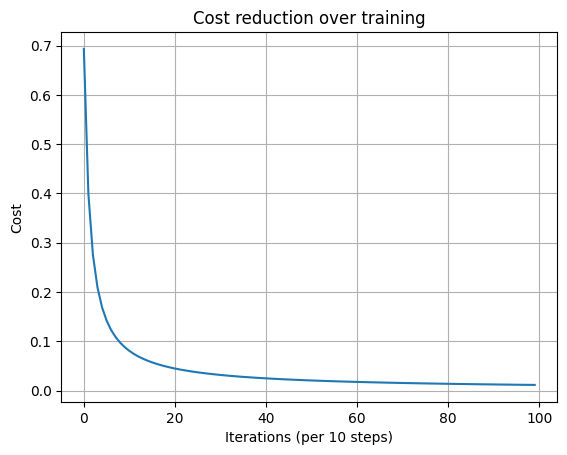

In [137]:
import matplotlib.pyplot as plt

plt.plot(logistic_regression_model['costs'])
plt.ylabel('Cost')
plt.xlabel('Iterations (per 10 steps)')
plt.title('Cost reduction over training')
plt.grid(True)
plt.show()


## Conclusion

This project demonstrates how a logistic regression classifier can be implemented from scratch using basic linear algebra and optimization.

The model achieves decent accuracy on a small subset of the Cats vs Dogs dataset, proving that even simple models can be powerful when built and tuned carefully.
